In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV
from sklearn.metrics import recall_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import itertools
wine = pd.read_csv('../datasets/wine.csv')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Learning Curve Definition

In [2]:
# Courtesy of http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


# Confusion Matrix Definition

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data

In [4]:
wine.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [5]:
X = wine.drop('quality', axis=1)
y = wine['quality']

# Data Preprocessing

In [6]:
scaler = StandardScaler()

In [7]:
# Fit to training data
scaler.fit(X)
X = scaler.transform(X)

# Train Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Default Model

In [9]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
print clf.score(X_test, y_test)

0.5825


Confusion matrix, without normalization
[[  0   0   1   2   0   0]
 [  0   2   5   7   0   0]
 [  2   3 113  39   4   0]
 [  0   2  54 101  12   0]
 [  0   0   7  23  17   0]
 [  0   0   0   3   3   0]]


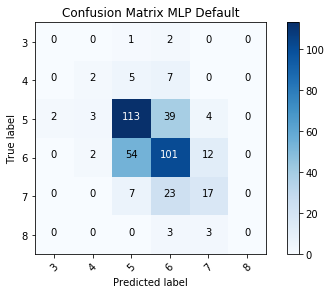

In [11]:
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['3','4','5','6','7','8'], title='Confusion Matrix MLP Default')
plt.show()
plt.clf()

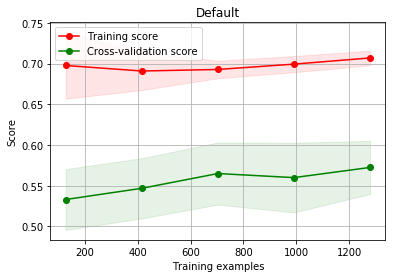

In [12]:
#     Plot learning curve
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

plot_learning_curve(clf, "Default", X, y, ylim=None, cv=cv, n_jobs=4).show()

# Grid Search Ball Tree

In [ ]:
%%capture output
# Set the parameters by cross-validation
tuned_parameters = [{'n_neighbors': [1, 5, 10, 15, 20], 
                     'weights': ['uniform', 'distance'],
                     'leaf_size': [1, 10, 20, 30, 40, 50],
                     'p': [1, 2, 3]}]

scores = ['accuracy', 'precision_macro', 'recall_macro']

bt_clf = []

for score in scores:
    plt.clf()
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(KNeighborsClassifier(algorithm='ball_tree'), tuned_parameters, cv=5, verbose=0, scoring=score, n_jobs=4)
    clf.fit(X, y)

    plot_learning_curve(clf, scores[1], X, y, ylim=None, cv=cv, n_jobs=4).show()

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print

    print("Detailed classification report:")
    print
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print
    y_true, y_pred = y, clf.predict(X)
    print(classification_report(y_true, y_pred))
    print
    bt_clf.append(clf)


# Grid Search KD Tree

In [ ]:
# Set the parameters by cross-validation
tuned_parameters = [{'n_neighbors': [1, 5, 10, 15, 20], 
                     'weights': ['uniform', 'distance'],
                     'leaf_size': [1, 10, 20, 30, 40, 50],
                     'p': [1, 2, 3]}]

scores = ['accuracy', 'precision_macro', 'recall_macro']

kd_clf = []

for score in scores:
    plt.clf()
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(KNeighborsClassifier(algorithm='kd_tree'), tuned_parameters, cv=5, verbose=0, scoring=score, n_jobs=4)
    clf.fit(X, y)

    plot_learning_curve(clf, scores[1], X, y, ylim=None, cv=cv, n_jobs=4).show()

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print

    print("Detailed classification report:")
    print
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print
    y_true, y_pred = y, clf.predict(X)
    print(classification_report(y_true, y_pred))
    print
    kd_clf.append(clf)


# Grid Search Brute

In [ ]:
# Set the parameters by cross-validation
tuned_parameters = [{'n_neighbors': [1, 5, 10, 15, 20], 
                     'weights': ['uniform', 'distance'],
                     'leaf_size': [1, 10, 20, 30, 40, 50],
                     'p': [1, 2, 3]}]

scores = ['accuracy', 'precision_macro', 'recall_macro']

brute_clf = []

for score in scores:
    plt.clf()
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(KNeighborsClassifier(algorithm='brute'), tuned_parameters, cv=5, verbose=0, scoring=score, n_jobs=4)
    clf.fit(X, y)

    plot_learning_curve(clf, scores[1], X, y, ylim=None, cv=cv, n_jobs=4).show()

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print

    print("Detailed classification report:")
    print
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print
    y_true, y_pred = y, clf.predict(X)
    print(classification_report(y_true, y_pred))
    print
    brute_clf.append(clf)


In [ ]:
output.show()

In [ ]:
n_neighbors = 15
h = 0.02
X_train = X_train.values
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [ ]:
# Courtesy of http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
for weights in ['uniform', 'distance']:
    # Create instance of Neighbours Classifier
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_train, y_train)
    
    accur = clf.score(X_test, y_test)
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X.values[:, 0], X.values[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    
    # Circle out the test data
    plt.scatter(X_test.values[:, 0], X_test.values[:, 1], s=80, facecolors='none',
                zorder=10, edgecolor='k')
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))
    
    print accur

plt.show()

In [ ]:
# Now to grid search for a really good model
tuned_parameters = [{'weights': ['uniform', 'distance'],
                     'n_neighbors': range(1,20, 2),
                     'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                     'leaf_size': range(1,30,2),
                     'p': [1,2,5,10]}]

scores = ['accuracy', 'precision_macro', 'recall_macro']
for fig_num, score in enumerate(scores):
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(neighbors.KNeighborsClassifier(), tuned_parameters, cv=5,
                       scoring=score)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))

    print("Detailed classification report:")
    y_true, y_pred = y, clf.predict(X)

    plt.clf()
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X.values[:, 0], X.values[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(score)
    print(classification_report(y_true, y_pred))
    plt.show()

### Two Classes (quality 3 and 8)

In [ ]:
X = wine.drop('quality', axis=1)
y = wine['quality']

In [ ]:
X = X[(y == 3) | (y == 8)]
y = y[(y == 3) | (y == 8)]
X = X[['residual sugar', 'alcohol']]
print X.shape
print y.shape

In [ ]:
h = 0.02
X = X.values
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [ ]:
# Now to grid search for a really good model
tuned_parameters = [{'weights': ['uniform', 'distance'],
                     'n_neighbors': range(1,20, 2),
                     'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                     'leaf_size': range(1,30,2),
                     'p': [1,2,5,10]}]

scores = ['accuracy', 'precision_macro', 'recall_macro']
for fig_num, score in enumerate(scores):
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(neighbors.KNeighborsClassifier(), tuned_parameters, cv=5,
                       scoring=score)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))

    print("Detailed classification report:")
    y_true, y_pred = y, clf.predict(X)

    plt.clf()
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(score)
    print(classification_report(y_true, y_pred))
    plt.show()